# Notebook for analyzing the results obtained from larger networks

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from bnsl.metrics import compute_shd
from typing import List, Tuple
from math import log10, floor

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /usr/lib/R
INFO:rpy2.situation:R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
INFO:rpy2.situation:LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface:Environment variable "PWD" redefined by R and overriding existing variable. Current: "/mnt/c/Users/Aurora Ingebrigtsen/AppData/Local/Programs/Microsoft VS Code", R: "/home/aurora/source/repos/bn-structure-learning/experiments/notebooks"
INFO:rpy2.rinterface:R is already initialized. No need to initialize.


In [2]:
root = Path.cwd().parents[1]    # two levels up
files = list((root / "data" / "results" / "medium").rglob("*.json"))

In [3]:
records = []
for f in files:
    with open(f) as fp:
        r = json.load(fp)
        record = {
            "algorithm": r["algorithm"],
            "network": r["network"].split("/")[-1].split(".")[0],
            "num_samples": r["num_samples"],
            "score": r["score"],
            "theoretical_upper_bound": r["bounds"].get("theoretical_upper_bound"),
            "naive_upper_bound": r["bounds"].get("naive_upper_bound"),
            "runtime": r["seconds_elapsed"],
            "k": r["params"].get("k"),
            "l": r["params"].get("l"),
            "num_vars": r["num_variables"],
            "seed": r["seed"],
            "parent_map": r.get("parent_map"),
        }
        records.append(record)

df = pd.DataFrame(records)

In [4]:
df.head()

,algorithm,network,num_samples,score,theoretical_upper_bound,naive_upper_bound,runtime,k,l,num_vars,seed,parent_map
0,approximation_algorithm,child,10000,-124265.533,-32776.350,-99723.130,8.349,3,2,20,42,"{'Age': ['Disease', 'Sick'], 'BirthAsphyxia': ..."
1,approximation_algorithm,insurance,1000,-14186.740,8556.927,-10566.744,4.541,2,1,27,44,"{'0': ['10'], '1': ['12', '13', '8'], '10': ['..."
2,approximation_algorithm,child,100,-1556.014,126.912,-1431.427,0.471,2,1,20,44,"{'Age': ['Grunting'], 'BirthAsphyxia': [], 'CO..."
3,approximation_algorithm,child,10000,-123373.220,-77405.551,-99723.130,95.530,5,4,20,43,"{'Age': [], 'BirthAsphyxia': [], 'CO2': ['CO2R..."
4,approximation_algorithm,insurance,10000,-135005.963,97693.117,-93442.791,7.318,2,1,27,43,"{'0': ['3'], '1': ['12', '13', '8'], '10': ['0..."


##### Look at the number of ideals generated for each partial order 

In [5]:
def get_size_of_ideals(n:int, l: int, k: int) -> int:
    """ Returns the expected number of ideals for a partial order, given l and k values.
     Based on lemma 19 from Partial Order Approach paper: |I(B)| = 1−ℓ+2**|B1|+2**|B2|+···+2**|Bℓ|"""
    
    q, r = divmod(n, k) #partition n into k equally sized sets:  r sets of size q+1, (k-r) sets  of size q

    if l <= r:
        size_big = l * (q + 1)

        num_small_q_plus_1 = r - l 
        num_small_q = k - r  
        L = num_small_q_plus_1 + num_small_q + 1

        return (1- L+ num_small_q_plus_1 * (2 ** (q + 1)) + num_small_q * (2 ** q) + (2 ** size_big))
    else: # l > r
        size_big = r * (q + 1) + (l - r) * q

        num_small_q = k - l 
        L = num_small_q + 1

        return (1- L+ num_small_q * (2 ** q) + (2 ** size_big))

In [6]:
networks_sorted = [
    ("CHILD", 20),
    ("INSURANCE", 27),
    ("WATER", 32),
    ("MILDEW", 35),
    ("ALARM", 37),
    ("HAILFINDER", 56),
    ("CARPO", 60),
]

k_l_grid: List[Tuple[int, int]] = [
    (2, 1),
    (3, 2),
    (4, 3),
    (5, 4),
]

def to_sci_latex(x: int) -> str:
    """
    Format integer x  in latex 
    """
    if x == 0:
        return "$0$"
    exp = floor(log10(x))
    mant = x / (10 ** exp)
    # 2 decimal digits 
    return f"${mant:.2f} \\times 10^{{{exp}}}$"

# Print LaTeX table
print(r"\begin{table}[H]")
print(r"\centering")
print(r"\begin{tabular}{l r " + "r" * len(k_l_grid) + "}")
print(r"\toprule")

# Header row
header = [r"\textbf{Network}", r"\textbf{Nodes $n$}"]
for k, l in k_l_grid:
    header.append(fr"$\mathbf{{(k={k},\,\ell={l})}}$")
print(" & ".join(header) + r" \\")
print(r"\midrule")

# Data rows
for name, n in networks_sorted:
    row = [name, str(n)]
    for k, l in k_l_grid:
        ideals_size = get_size_of_ideals(n, l, k)
        row.append(to_sci_latex(ideals_size))
    print(" & ".join(row) + r" \\")
print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\caption{Number of ideals generated by the first partial order "
      r"for different $(k,\ell)$ values.}")
print(r"\end{table}")

\begin{table}[H]
\centering
\begin{tabular}{l r rrrr}
\toprule
\textbf{Network} & \textbf{Nodes $n$} & $\mathbf{(k=2,\,\ell=1)}$ & $\mathbf{(k=3,\,\ell=2)}$ & $\mathbf{(k=4,\,\ell=3)}$ & $\mathbf{(k=5,\,\ell=4)}$ \\
\midrule
CHILD & 20 & $2.05 \times 10^{3}$ & $1.64 \times 10^{4}$ & $3.28 \times 10^{4}$ & $6.56 \times 10^{4}$ \\
INSURANCE & 27 & $2.46 \times 10^{4}$ & $2.63 \times 10^{5}$ & $2.10 \times 10^{6}$ & $4.19 \times 10^{6}$ \\
WATER & 32 & $1.31 \times 10^{5}$ & $4.20 \times 10^{6}$ & $1.68 \times 10^{7}$ & $6.71 \times 10^{7}$ \\
MILDEW & 35 & $3.93 \times 10^{5}$ & $1.68 \times 10^{7}$ & $1.34 \times 10^{8}$ & $2.68 \times 10^{8}$ \\
ALARM & 37 & $7.86 \times 10^{5}$ & $3.36 \times 10^{7}$ & $2.68 \times 10^{8}$ & $1.07 \times 10^{9}$ \\
HAILFINDER & 56 & $5.37 \times 10^{8}$ & $2.75 \times 10^{11}$ & $4.40 \times 10^{12}$ & $3.52 \times 10^{13}$ \\
CARPO & 60 & $2.15 \times 10^{9}$ & $1.10 \times 10^{12}$ & $3.52 \times 10^{13}$ & $2.81 \times 10^{14}$ \\
\bottomrule
\end{

##### Plot analytical score against empirical runtime

Saved /home/aurora/source/repos/bn-structure-learning/experiments/plots/runtime_scaling_child.png


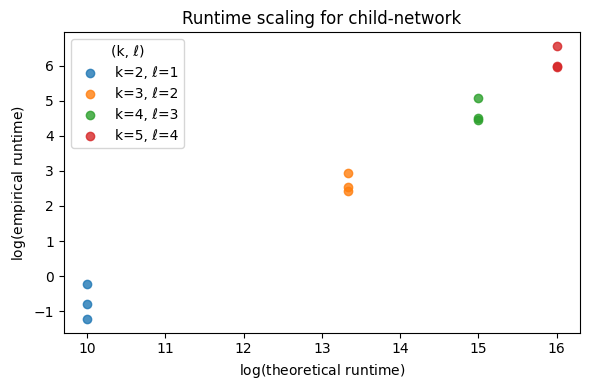

Saved /home/aurora/source/repos/bn-structure-learning/experiments/plots/runtime_scaling_insurance.png


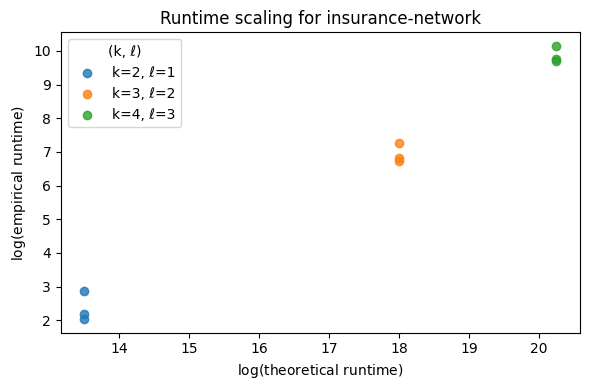

In [ ]:
df_avg = (
    df.groupby(["network", "num_samples", "k", "l", "num_vars"])
      .agg(runtime=("runtime", "mean"))
      .reset_index()
)

df_avg["theory_log"] = (df_avg["l"] / df_avg["k"]) * df_avg["num_vars"] # log_2(2**(l/k * n)) = (l/k)*n
df_avg["actual_log"] = np.log2(df_avg["runtime"])

networks = df_avg["network"].unique()

for net in networks:
    subset = df_avg[df_avg["network"] == net]

    plt.figure(figsize=(6, 4))

    # one scatter series per (k, l)
    for (k, l), sub2 in subset.groupby(["k", "l"]):
        plt.scatter(
            sub2["theory_log"],
            sub2["actual_log"],
            label=f"k={k}, ℓ={l}",
            alpha=0.8,
        )

    plt.title(f"Runtime scaling for {net}-network")
    plt.xlabel(r"$\log(\text{theoretical runtime})$")
    plt.ylabel(r"$\log(\text{empirical runtime})$")
    plt.legend(title="(k, ℓ)")
    plt.tight_layout()

    outfile = root / f"experiments/plots/runtime_scaling_{net}.png"
    plt.savefig(outfile, dpi=300) 
    print(f"Saved {outfile}")
    plt.show()

##### Score vs runtime

In [17]:
df_agg = (
    df.groupby(["num_samples", "network", "k", "l"], as_index=False)
      .agg(
          score=("score", "mean"),
          naive_upper_bound=("naive_upper_bound", "mean"),
      )
)

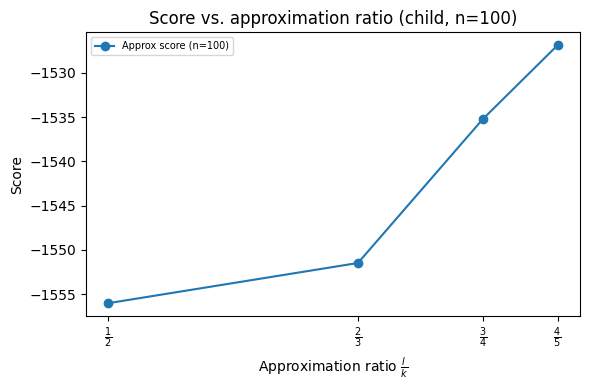

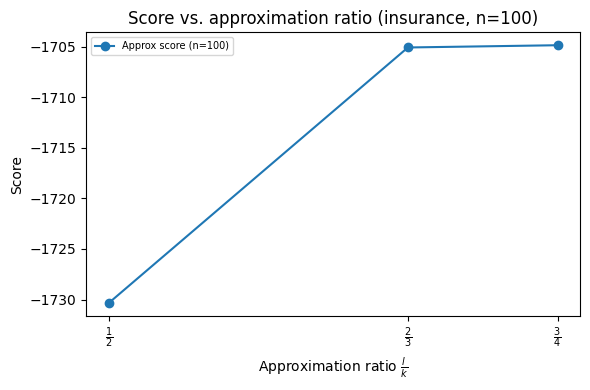

In [21]:
# Filter to a single sample size
TARGET_N = 100
df_1000 = df_agg[df_agg["num_samples"] == TARGET_N].copy()

# Add approximation ratio
df_1000["ratio"] = df_1000["l"] / df_1000["k"]

# Plot one figure per network
for net, sub in df_1000.groupby("network"):
    plt.figure(figsize=(6, 4))

    # Sort by ratio so the line is monotone
    sub = sub.sort_values("ratio")

    x = sub["ratio"].to_numpy()
    y = sub["score"].to_numpy()

    # Approximation score curve
    plt.plot(
        x,
        y,
        marker="o",
        linestyle="-",
        label=f"Approx score (n={TARGET_N})"
    )



    kl_list = [tuple(x) for x in sub[["k", "l"]].drop_duplicates().to_numpy()]
    kl_list = sorted(kl_list)

    xticks = [l / k for (k, l) in kl_list]
    xticklabels = [fr"$\frac{{{int(l)}}}{{{int(k)}}}$" for (k, l) in kl_list]

    plt.xticks(xticks, xticklabels)

    plt.xlabel(r"Approximation ratio $\frac{l}{k}$")
    plt.ylabel("Score")
    plt.title(f"Score vs. approximation ratio ({net}, n={TARGET_N})")
    plt.legend(fontsize=7)
    plt.tight_layout()

    outfile = root / f"experiments/plots/plot_score_vs_ratio_{net}_n{TARGET_N}.png"
    plt.show()

Saved /home/aurora/source/repos/bn-structure-learning/experiments/plots/exp_base_vs_ratio_child.png


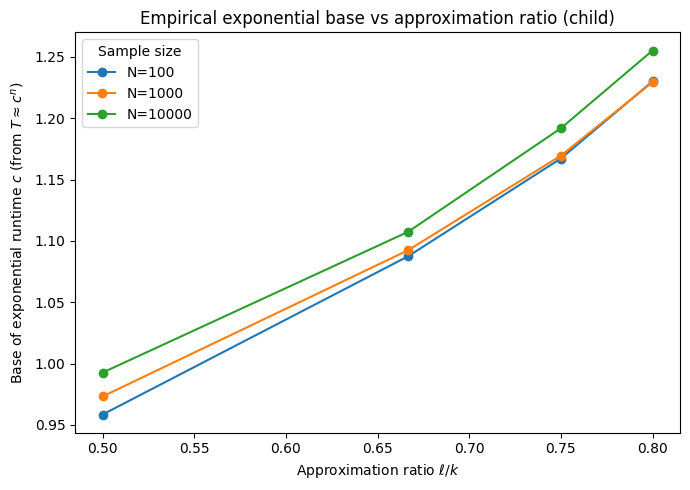

Saved /home/aurora/source/repos/bn-structure-learning/experiments/plots/exp_base_vs_ratio_insurance.png


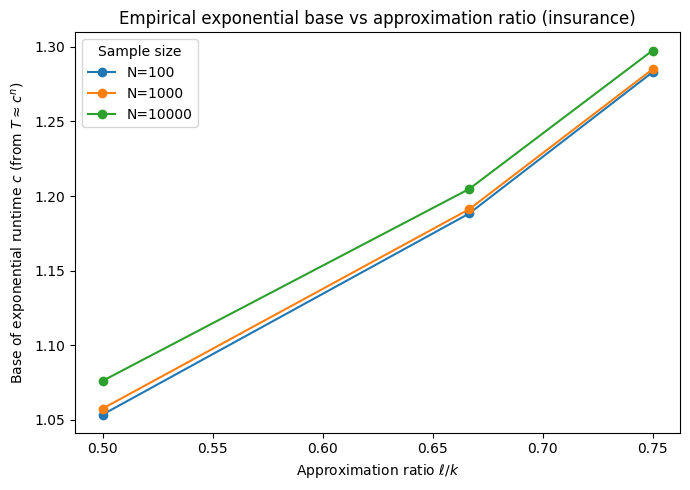

In [ ]:
df_avg = (
    df.groupby(["network", "num_samples", "k", "l", "num_vars"])
      .agg(runtime=("runtime", "mean"))
      .reset_index()
)

df_avg["ratio"] = df_avg["l"] / df_avg["k"]

# Compute base c such that runtime ≈ c^n
df_avg["exp_base"] = df_avg["runtime"] ** (1 / df_avg["num_vars"])

networks = df_avg["network"].unique()

for net in networks:
    subset_net = df_avg[df_avg["network"] == net]
    sample_sizes = subset_net["num_samples"].unique()

    plt.figure(figsize=(7, 5))

    for S in sorted(sample_sizes):
        sub = subset_net[subset_net["num_samples"] == S].sort_values("ratio")

        plt.plot(
            sub["ratio"],
            sub["exp_base"],
            marker="o",
            label=f"N={S}"
        )

    plt.xlabel(r"Approximation ratio $\ell/k$")
    plt.ylabel(r"Base of exponential runtime")

    plt.title(f"Empirical exponential base vs approximation ratio ({net})")
    plt.legend(title="Sample size")
    plt.tight_layout()

    outfile = root / f"experiments/plots/exp_base_vs_ratio_{net}.png"
    plt.savefig(outfile, dpi=300)
    print(f"Saved {outfile}")

    plt.show()


Saved /home/aurora/source/repos/bn-structure-learning/experiments/plots/score_vs_runtime_child_N1000.png


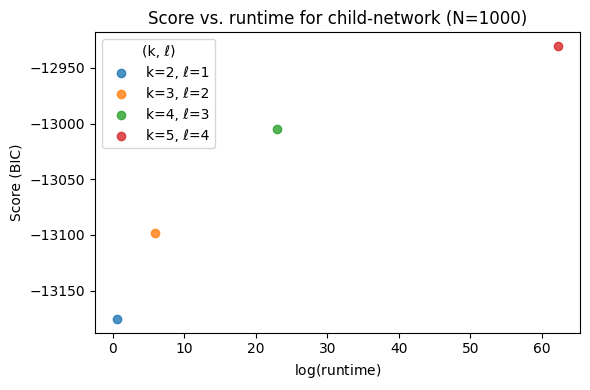

Saved /home/aurora/source/repos/bn-structure-learning/experiments/plots/score_vs_runtime_insurance_N1000.png


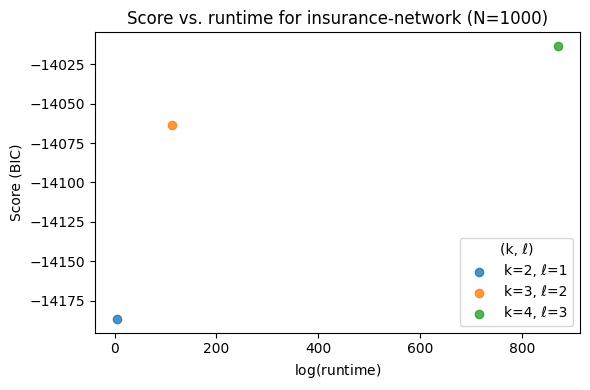

In [31]:
S = 1000

df_fixed = df[df["num_samples"] == S]

df_avg = (
    df_fixed.groupby(["network", "k", "l"])
            .agg(runtime=("runtime", "mean"),
                 score=("score", "mean"))
            .reset_index()
)

df_avg["log_runtime"] = np.log(df_avg["runtime"])

networks = df_avg["network"].unique()

for net in networks:
    subset = df_avg[df_avg["network"] == net]

    plt.figure(figsize=(6, 4))

    for (k, l), sub2 in subset.groupby(["k", "l"]):
        plt.scatter(
            sub2["runtime"],
            sub2["score"],
            label=f"k={k}, ℓ={l}",
            alpha=0.8,
        )

    plt.title(f"Score vs. runtime for {net}-network (N={S})")
    plt.xlabel(r"$\log(\text{runtime})$")
    plt.ylabel("Score (BIC)")
    plt.legend(title="(k, ℓ)")
    plt.tight_layout()

    outfile = root / f"experiments/plots/score_vs_runtime_{net}_N{S}.png"
    plt.savefig(outfile, dpi=300)
    print(f"Saved {outfile}")

    plt.show()


##### For fun: How close is the 56-node network we can find by running approximation algorithm?